In [40]:
import sys
sys.path.append('../code/') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from copy import deepcopy
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
# device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [41]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')
num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
# Filter dataframes to separate object, body, and eye markers
proxjoint_markers = ['carpal', 'radiusProx', 'radiusDistal', 'ulnarProx', 'ulnarDistal']
eye_markers = ['eye', 'cornea']
finger_markers = ['ring', 'pinky', 'thumb', 'index', 'middle']
proxjoint_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in proxjoint_markers])
finger_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in finger_markers])
eye_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in eye_markers])


proxjoint_df = kinematic_df[proxjoint_mask]
finger_df = kinematic_df[finger_mask]
eyes_df = kinematic_df[eye_mask]

finger_proxjoint_df = pd.concat([finger_df, proxjoint_df])


### Use function to create train/test sets with each data frame

In [24]:
def make_generators(pred_df, neural_df, neural_offset, cv_dict):
    sampling_rate = 100
    kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
    offset = neural_offset + kernel_offset
    window_size = 1
    data_step_size = 1 

    # Set up PyTorch Dataloaders
    fold=0
    kinematic_type = 'posData'
    # Parameters
    batch_size = 10000
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

    predict_kinematics=False
    # Generators
    training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', pred_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', pred_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', pred_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    data_arrays = (X_train_data, y_train_data, X_test_data, y_test_data)
    generators = (training_generator, training_eval_generator, validation_generator)

    return data_arrays, generators 

def run_wiener(pred_df, neural_df, neural_offset, cv_dict):
    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset, cv_dict)

    # Unpack tuple into variables
    X_train_data, y_train_data, X_test_data, y_test_data = data_arrays
    training_generator, training_eval_generator, validation_generator = generators

    #Fit and run wiener filter
    model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
    model_wr.fit(X_train_data,y_train_data)

    wr_train_pred = model_wr.predict(X_train_data)
    wr_test_pred = model_wr.predict(X_test_data)

    #Compute decoding
    wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
    wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

    return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_ann(pred_df, neural_df, neural_offset):
    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset)

    # Unpack tuple into variables
    X_train_data, y_train_data, X_test_data, y_test_data = data_arrays
    training_generator, training_eval_generator, validation_generator = generators

    #Define hyperparameters
    lr = 1e-3
    weight_decay = 1e-5
    layer_size=[100]
    max_epochs=1000
    input_size = X_train_data.shape[1] 
    output_size = y_train_data.shape[1] 

    model_ann = mocap_functions.model_ann(input_size,output_size,layer_size).to(device)
    # Define Loss, Optimizerints h
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

    #Train model
    loss_dict = mocap_functions.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

    #Evaluate trained model
    ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
    ann_test_pred = mocap_functions.evaluate_model(model_ann, validation_generator, device)

    return ann_train_pred, ann_test_pred, ann_train_corr, ann_test_corr
    

### Generate decoding results

In [50]:
all_offset, proxjoint_offset, finger_offset, eyes_offset, finger_proxjoint_offset = 20, 20, 20, 20, 20

all_test_pred_l, proxjoint_test_pred_l, finger_test_pred_l, eyes_test_pred_l, finger_proxjoint_test_pred_l = list(), list(), list(), list(), list()

y_test_data_l = list()

for layout_idx in range(1,5):
    kinematic_df_layout = kinematic_df[kinematic_df['layout'] == layout_idx]
    neural_df_layout = neural_df[neural_df['layout'] == layout_idx]

    trials_layout = np.unique(kinematic_df_layout['trial'].unique())

    proxjoint_mask_layout = np.logical_or.reduce([kinematic_df_layout['name'].str.contains(pat=pat) for pat in proxjoint_markers])
    finger_mask_layout = np.logical_or.reduce([kinematic_df_layout['name'].str.contains(pat=pat) for pat in finger_markers])
    eye_mask_layout = np.logical_or.reduce([kinematic_df_layout['name'].str.contains(pat=pat) for pat in eye_markers])

    proxjoint_df_layout = kinematic_df_layout[proxjoint_mask_layout]
    finger_df_layout = kinematic_df_layout[finger_mask_layout]
    eyes_df_layout = kinematic_df_layout[eye_mask_layout]
    finger_proxjoint_df_layout = pd.concat([finger_df_layout, proxjoint_df_layout])

    # Filter trials in cv_dict
    cv_dict_layout = deepcopy(cv_dict)
    for fold_idx in cv_dict.keys():
        for split_name in cv_dict[fold_idx].keys():
            cv_trials = cv_dict[fold_idx][split_name].copy()
            trial_mask = np.in1d(cv_trials, trials_layout)
            cv_dict_layout[fold_idx][split_name] = cv_trials[trial_mask]

    all_train_pred, all_test_pred, all_train_corr, all_test_corr = run_wiener(kinematic_df_layout, neural_df_layout, all_offset, cv_dict_layout)
    proxjoint_train_pred, proxjoint_test_pred, proxjoint_train_corr, proxjoint_test_corr = run_wiener(proxjoint_df_layout, neural_df_layout, proxjoint_offset, cv_dict_layout)
    finger_train_pred, finger_test_pred, finger_train_corr, finger_test_corr = run_wiener(finger_df_layout, neural_df_layout, finger_offset, cv_dict_layout)
    eyes_train_pred, eyes_test_pred, eyes_train_corr, eyes_test_corr = run_wiener(eyes_df_layout, neural_df_layout, eyes_offset, cv_dict_layout)

    finger_proxjoint_train_pred, finger_proxjoint_test_pred, finger_proxjoint_train_corr, finger_proxjoint_test_corr = run_wiener(finger_proxjoint_df_layout, neural_df_layout, finger_proxjoint_offset, cv_dict_layout)


    # Unpack tuple into variables
    data_arrays, _ = make_generators(kinematic_df_layout, neural_df_layout, eyes_offset, cv_dict_layout)
    X_train_data, y_train_data, X_test_data, y_test_data = data_arrays

    all_test_pred_l.append(all_test_pred)
    proxjoint_test_pred_l.append(proxjoint_test_pred)
    finger_test_pred_l.append(finger_test_pred)
    eyes_test_pred_l.append(eyes_test_pred)
    finger_proxjoint_test_pred_l.append(finger_proxjoint_test_pred)

    y_test_data_l.append(y_test_data)



In [51]:
all_test_corr = mocap_functions.matrix_corr(np.concatenate(all_test_pred_l), np.concatenate(y_test_data_l))
proxjoint_test_corr = mocap_functions.matrix_corr(np.concatenate(proxjoint_test_pred_l), np.concatenate(y_test_data_l))
finger_test_corr = mocap_functions.matrix_corr(np.concatenate(finger_test_pred_l), np.concatenate(y_test_data_l))
eyes_test_corr = mocap_functions.matrix_corr(np.concatenate(eyes_test_pred_l), np.concatenate(y_test_data_l))
finger_proxjoint_test_corr = mocap_functions.matrix_corr(np.concatenate(finger_proxjoint_test_pred_l), np.concatenate(y_test_data_l))


(0.0, 0.8)

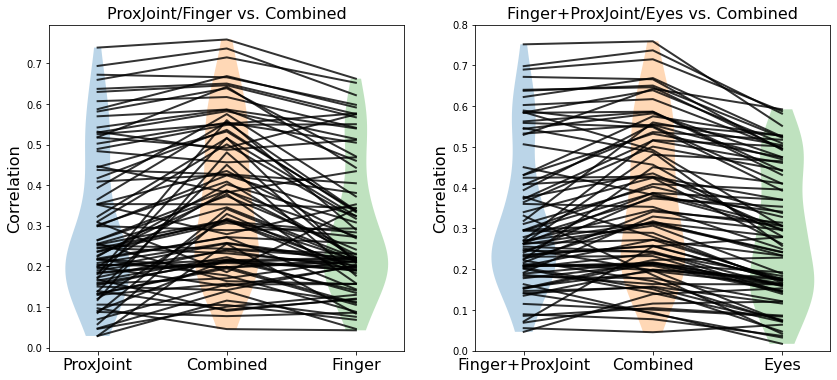

In [53]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_data = np.stack([proxjoint_test_corr, all_test_corr, finger_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['ProxJoint', 'Combined', 'Finger'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(finger_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('ProxJoint/Finger vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.subplot(1,2,2)
plot_data = np.stack([finger_proxjoint_test_corr, all_test_corr, eyes_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['Finger+ProxJoint', 'Combined', 'Eyes'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(finger_proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(eyes_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('Finger+ProxJoint/Eyes vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.savefig('single_unit_pred_layout.svg')

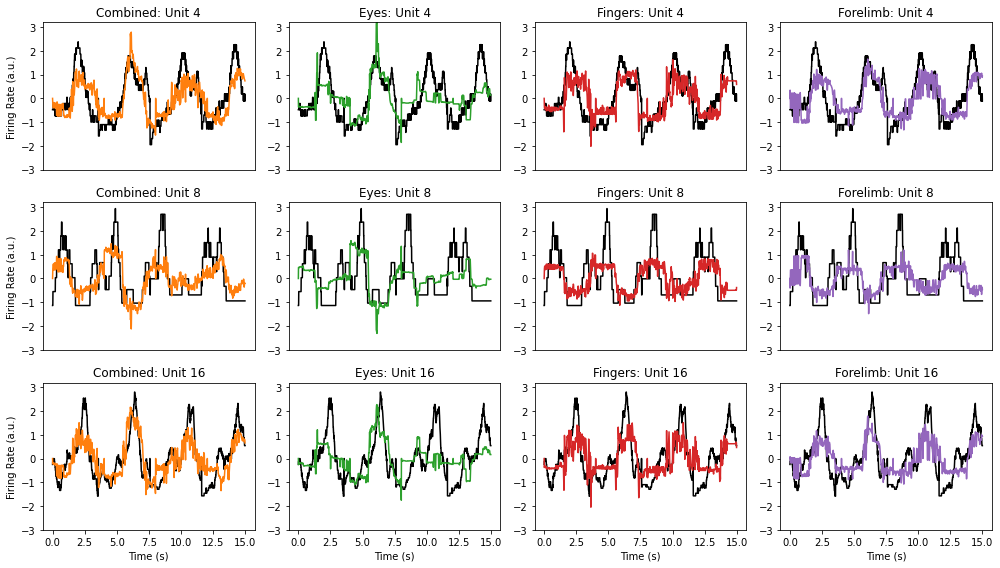

In [7]:
compare_data_list = [all_test_pred, eyes_test_pred, finger_test_pred, proxjoint_test_pred]
compare_data_names = ['Combined', 'Eyes', 'Fingers', 'Forelimb']

#Testing Data
plt.figure(figsize=(14,8))
bounds = np.arange(0,1500)
x_vals = np.arange(len(bounds))/100
unit_list = [4, 8, 16]

for row_idx, unit_idx in enumerate(unit_list):
    for plot_idx, (compare_data, name) in enumerate(zip(compare_data_list, compare_data_names)):
        plt.subplot(3,4, plot_idx+1 + (4*row_idx))
        plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
        plt.plot(x_vals, compare_data[bounds,unit_idx], color=f'C{plot_idx + 1}')
        plt.title(f'{name}: Unit {unit_idx}')
        plt.ylim([-3, 3.2])
        
        if plot_idx == 0:
            plt.ylabel('Firing Rate (a.u.)')
            
        if row_idx == 2:
            plt.xlabel('Time (s)')
        else:
            plt.xticks([])

    plt.tight_layout()